<a href="https://colab.research.google.com/github/Mahadevan0507/TEST/blob/main/Gold_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gold-price-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1479724%2F2445315%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T015325Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D627df623512a6d62394eaa95709aaa7f2f647160dac184cc9055700d59071f965041aa0d8131304ed1d2e451f5e66aa5937ea1d216079a6c3b5b6640925c8c52456de711df4d0ae9ad5acbf1a5ba1668469212856ce5bb1c78651d7a07463f414968401ef2b074596cf2511b8443740c8d7b5508cac0a7502c4068b0e48b082cf1db0a875a124d380374caa1b28d1f9a3defd48a41e7687688c49c0935c286c3022b6241a8b4d36c67bd879093e84714e6f93aabef5481aaaf8c7abd60ea4409235adc695acc5181a40f22b5b5c4c29c66ece839c181a7c4a40d74f42c587d7947c0856ee469f98f6d936cde3f61171a30c4cd8e0406e2ff1cc8a769f933a9b9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 379629 bytes downloaded
Downloaded and uncompressed: gold-price-prediction-dataset
Data source import complete.


# Imports

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Load Data || Extract THe Data

In [3]:
df = pd.read_csv('/kaggle/input/gold-price-prediction-dataset/FINAL_USO.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,2018-12-24,119.570000,120.139999,119.570000,120.019997,120.019997,9736400,239.039993,240.839996,234.270004,...,20.650000,21.090000,21.090000,60507000,9.490000,9.520000,9.280000,9.290000,9.290000,21598200
1714,2018-12-26,120.620003,121.000000,119.570000,119.660004,119.660004,14293500,235.970001,246.179993,233.759995,...,20.530001,20.620001,20.620001,76365200,9.250000,9.920000,9.230000,9.900000,9.900000,40978800
1715,2018-12-27,120.570000,120.900002,120.139999,120.570000,120.570000,11874400,242.570007,248.289993,238.960007,...,20.700001,20.969999,20.969999,52393000,9.590000,9.650000,9.370000,9.620000,9.620000,36578700
1716,2018-12-28,120.800003,121.080002,120.720001,121.059998,121.059998,6864700,249.580002,251.399994,246.449997,...,20.570000,20.600000,20.600000,49835000,9.540000,9.650000,9.380000,9.530000,9.530000,22803400


# Data Cleaning and Wrangling || Preprocessing

In [5]:
df.shape

(1718, 81)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1718 non-null   object 
 1   Open           1718 non-null   float64
 2   High           1718 non-null   float64
 3   Low            1718 non-null   float64
 4   Close          1718 non-null   float64
 5   Adj Close      1718 non-null   float64
 6   Volume         1718 non-null   int64  
 7   SP_open        1718 non-null   float64
 8   SP_high        1718 non-null   float64
 9   SP_low         1718 non-null   float64
 10  SP_close       1718 non-null   float64
 11  SP_Ajclose     1718 non-null   float64
 12  SP_volume      1718 non-null   int64  
 13  DJ_open        1718 non-null   float64
 14  DJ_high        1718 non-null   float64
 15  DJ_low         1718 non-null   float64
 16  DJ_close       1718 non-null   float64
 17  DJ_Ajclose     1718 non-null   float64
 18  DJ_volum

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
print(df['Date'].dtypes)

datetime64[ns]


In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

Date             0
Open             0
High             0
Low              0
Close            0
                ..
USO_High         0
USO_Low          0
USO_Close        0
USO_Adj Close    0
USO_Volume       0
Length: 81, dtype: int64

In [10]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
count,1718,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,...,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03
mean,2015-07-06 19:29:15.995343360,127.323434,127.854237,126.777695,127.319482,127.319482,8.446327e+06,204.490023,205.372637,203.487014,...,26.384575,26.715012,25.924624,4.356515e+07,22.113417,22.307148,21.904657,22.109051,22.109051,1.922313e+07
min,2011-12-15 00:00:00,100.919998,100.989998,100.230003,100.500000,100.500000,1.501600e+06,122.059998,122.320000,120.029999,...,12.400000,12.470000,12.269618,4.729000e+06,7.820000,8.030000,7.670000,7.960000,7.960000,1.035100e+06
25%,2013-10-03 06:00:00,116.220001,116.540001,115.739998,116.052502,116.052502,5.412925e+06,170.392498,170.962506,169.577499,...,20.355000,20.585000,20.180950,2.259968e+07,11.420000,11.500000,11.300000,11.392500,11.392500,6.229500e+06
50%,2015-07-18 12:00:00,121.915001,122.325001,121.369999,121.795002,121.795002,7.483900e+06,205.464996,206.459999,204.430000,...,22.870001,23.054999,22.677604,3.730465e+07,16.450000,16.635001,16.040000,16.345000,16.345000,1.613015e+07
75%,2017-04-09 06:00:00,128.427494,129.087498,127.840001,128.470001,128.470001,1.020795e+07,237.292500,237.722500,236.147503,...,26.797500,27.317500,26.478154,5.697055e+07,34.419998,34.667499,34.110000,34.417499,34.417499,2.672375e+07
max,2018-12-31 00:00:00,173.199997,174.070007,172.919998,173.610001,173.610001,9.380420e+07,293.089996,293.940002,291.809998,...,56.770000,57.470001,54.617039,2.321536e+08,41.599998,42.299999,41.299999,42.009998,42.009998,1.102657e+08
std,NaN,17.526993,17.631189,17.396513,17.536269,17.536269,4.920731e+06,43.831928,43.974644,43.618940,...,10.490908,10.603110,9.886570,2.909151e+07,11.431056,11.478671,11.373997,11.432787,11.432787,1.575743e+07


# Data Visualization

## 1. Time Series Plot for Gold Prices:

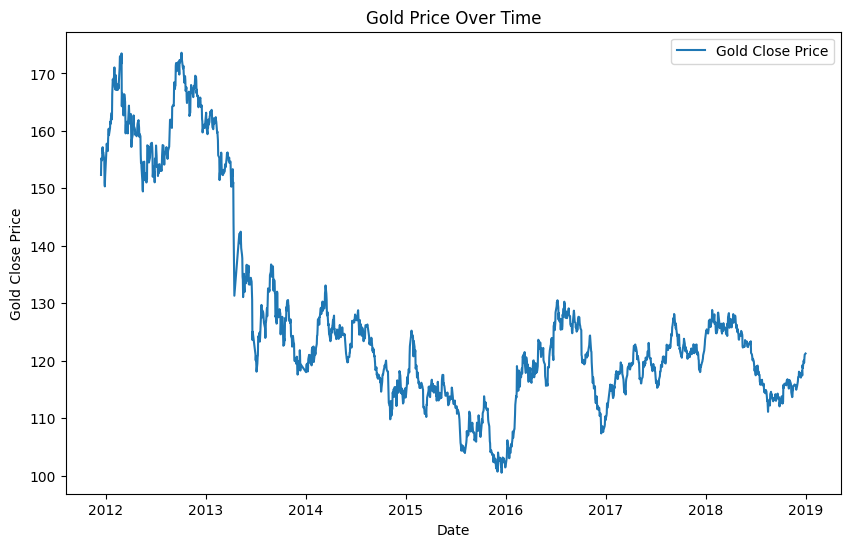

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Gold Close Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.legend()
plt.show()

## 2. Box Plots for Selected Columns:

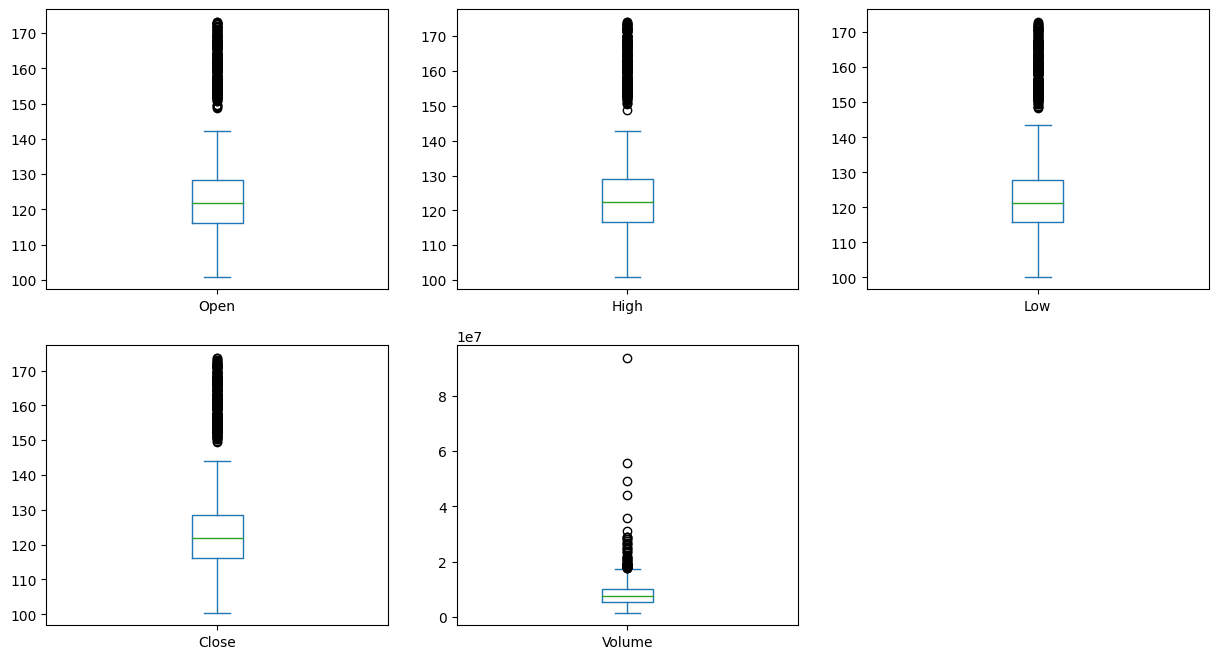

In [13]:
selected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df[selected_columns].plot(kind='box', subplots=True, layout=(2, 3), figsize=(15, 8), sharex=False, sharey=False)
plt.show()

## 3.Pair Plot for Selected Columns:

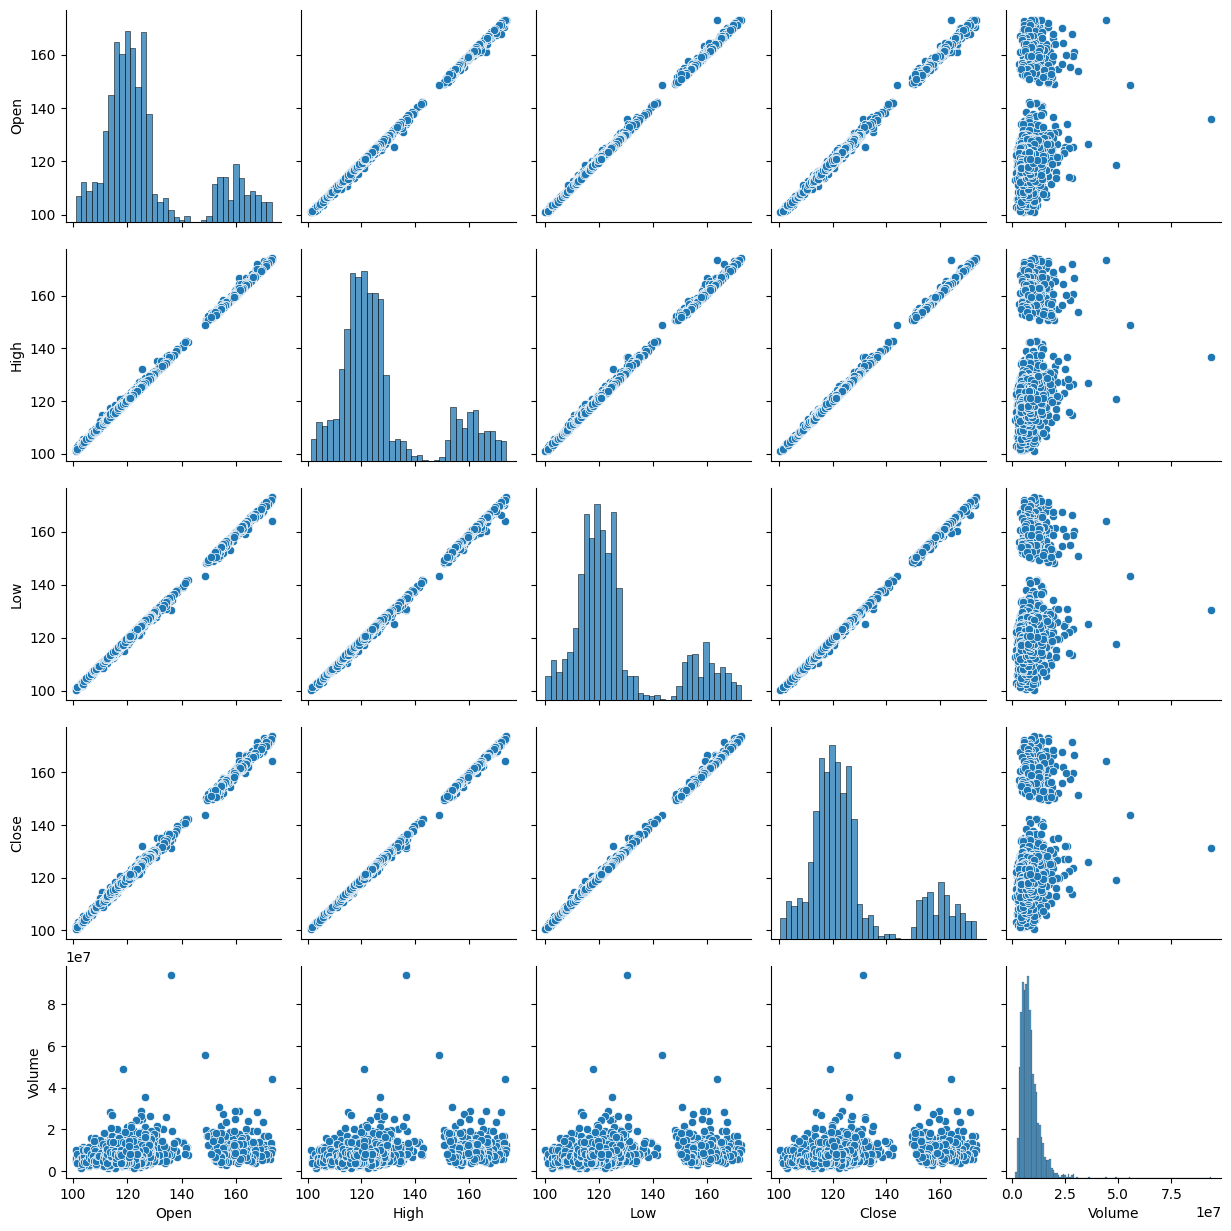

In [14]:
sns.pairplot(df[selected_columns])
plt.show()

## 4. Histogram of Gold Prices:

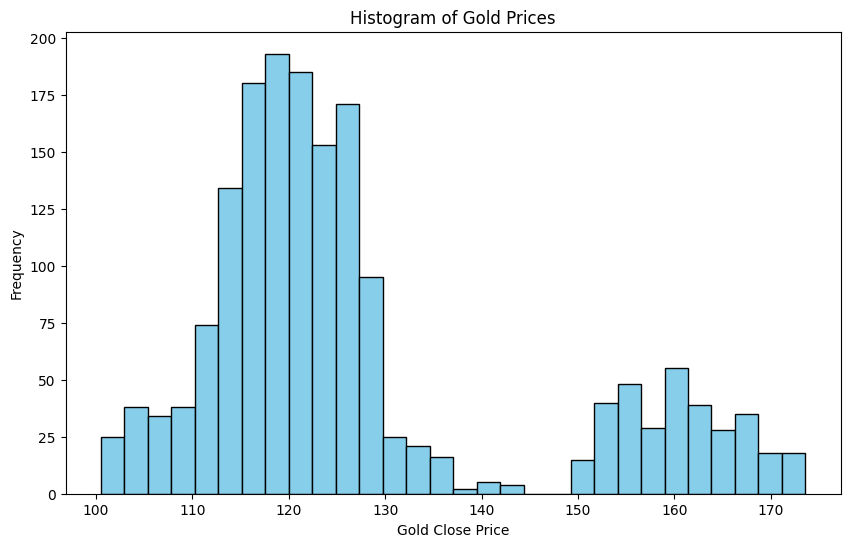

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(df['Close'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Gold Prices')
plt.xlabel('Gold Close Price')
plt.ylabel('Frequency')
plt.show()

# Model Building And Prediction

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Feature selection (you might want to choose different features)
features = ['Open', 'High', 'Low', 'Volume']

# Creating feature matrix X and target vector y
X = df[features]
y = df['Close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initialization and training
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.1145062522604036


In [17]:
from sklearn.metrics import mean_absolute_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


Mean Absolute Error: 0.2254835940525336
R-squared: 0.999632614159062


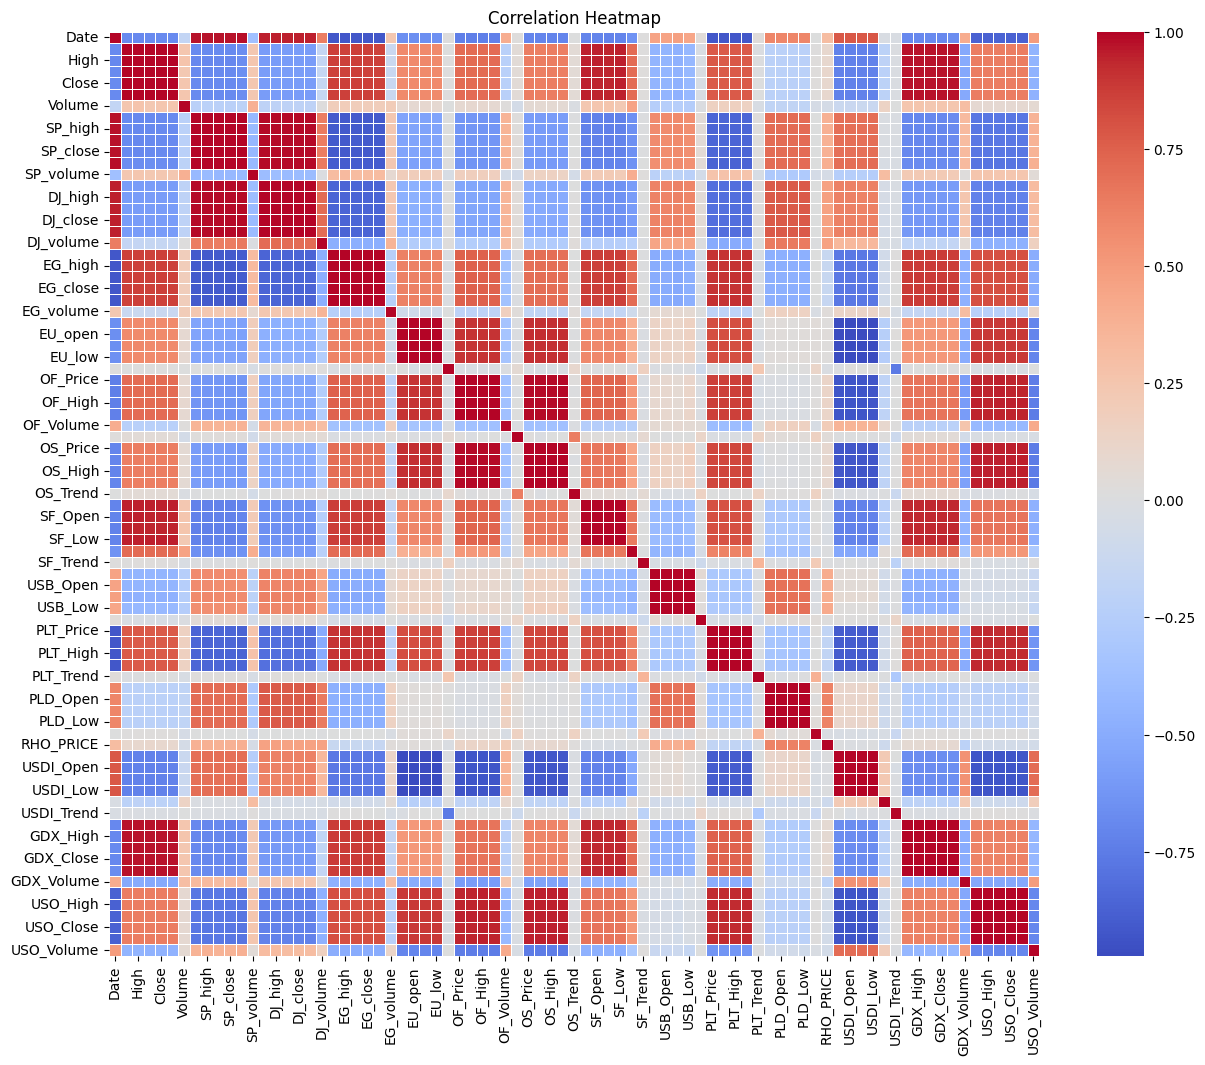

In [19]:
### Correlation Heatmap:

plt.figure(figsize=(15, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


Certainly! Here are a few more visualizations you can create to explore and analyze your data:

### Correlation Heatmap:

### Candlestick Chart for Stock Prices:
```python
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

ohlc = df[['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = mdates.date2num(ohlc['Date'])

plt.figure(figsize=(15, 8))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart for Gold Prices')
plt.xlabel('Date')
plt.ylabel('Gold Prices')
plt.show()
```

A candlestick chart provides a visual representation of price movements in the stock market. It shows the open, high, low, and close prices for each time period.

### Line Plot for Selected Columns:
```python
selected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df[selected_columns].plot(kind='line', figsize=(15, 8))
plt.title('Line Plot for Selected Columns')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc='upper left')
plt.show()
```


In [18]:
pip install mplfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.3 MB/s eta 0:00:00


## Candlestick Chart for Stock Prices:

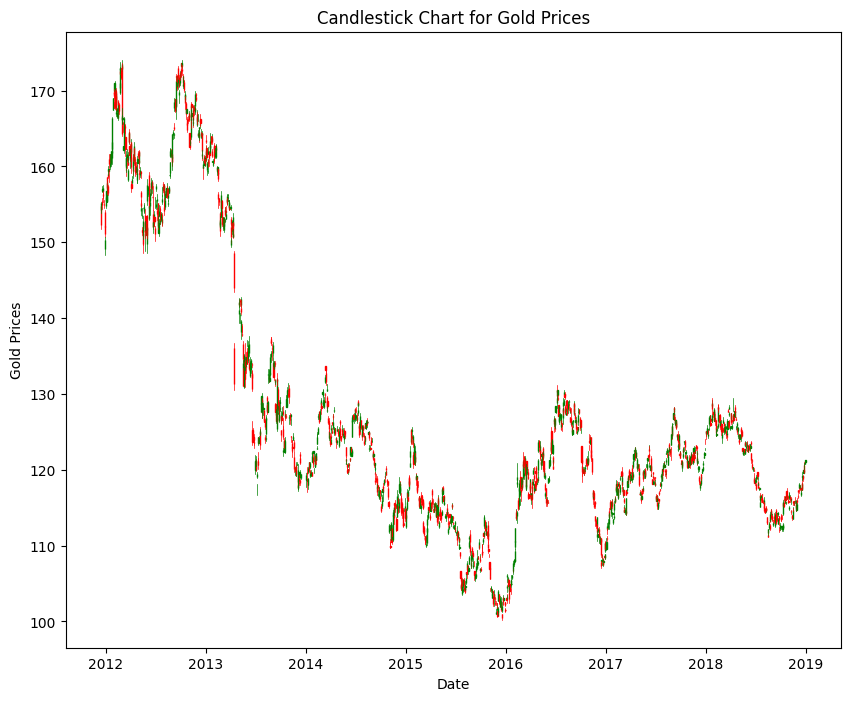

In [21]:

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

ohlc = df[['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = mdates.date2num(ohlc['Date'])

plt.figure(figsize=(10, 8))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart for Gold Prices')
plt.xlabel('Date')
plt.ylabel('Gold Prices')
plt.show()

## Line Plot for Selected Columns:

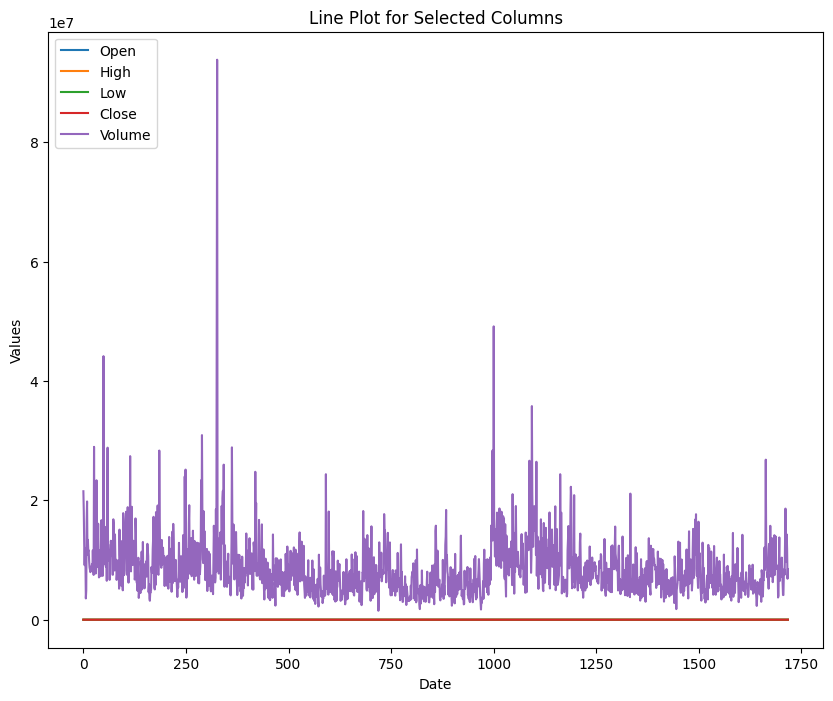

In [23]:

selected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df[selected_columns].plot(kind='line', figsize=(10, 8))
plt.title('Line Plot for Selected Columns')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc='upper left')
plt.show()